In [1]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from scipy import signal
import scipy.ndimage as im
import scipy.optimize as opt

from sympy import Symbol, pi, atan, factor, lambdify

import mitequinox.plot as pl
import mitequinox.sigp as sp

from fsspec.implementations.local import LocalFileSystem

In [2]:
from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
#
cluster = PBSCluster(processes=5, cores=5,walltime='02:00:00') #processes=7, cores=7
#
w = cluster.scale(jobs=4
                 )
#
client = Client(cluster)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
# Load Lagrangian data
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_T365j_dt1j_dij50'

In [4]:
parcels_index = 'autocov_demodulation_rr_flag10'
#'lpass_filtered_05cpd'
p = pa.parcels_output(root_dir+run_name, parquets=[parcels_index])
df = p[parcels_index]
df.head()


,trajectory,time,lon,lat,id,waterdepth,0.0,0.041666666666666664,0.08333333333333333,0.125,...,39.625,39.666666666666664,39.70833333333333,39.75,39.791666666666664,39.83333333333333,39.875,39.916666666666664,39.95833333333333,40.0
0,1000257,40.0,-39.460486,-78.206169,1000257.0,1120.851929,0.000018,0.000018,0.000018,0.000018,...,0.000004,0.000004,0.000004,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005
1,1000257,80.0,-39.802846,-78.161997,1000257.0,1129.803955,0.000050,0.000050,0.000050,0.000050,...,-0.000003,-0.000003,-0.000003,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004
2,1000257,120.0,NaN,NaN,1000257.0,NaN,0.000077,0.000077,0.000077,0.000076,...,-0.000053,-0.000053,-0.000054,-0.000054,-0.000054,-0.000054,-0.000054,-0.000054,-0.000054,-0.000054
3,2000583,40.0,-17.881071,-67.644213,2000583.0,4875.324707,0.000080,0.000080,0.000080,0.000080,...,-0.000026,-0.000027,-0.000027,-0.000028,-0.000028,-0.000029,-0.000029,-0.000030,-0.000030,-0.000031
4,2000583,80.0,-19.424687,-67.616589,2000583.0,4875.706543,0.000143,0.000143,0.000143,0.000143,...,-0.000035,-0.000036,-0.000036,-0.000037,-0.000038,-0.000038,-0.000039,-0.000040,-0.000040,-0.000041


In [47]:
df['energy'] = df['zonal_velocity_hat_real'].apply(lambda x : x**2)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py:3764: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('zonal_velocity_hat_real', 'float64'))

  warnings.warn(meta_warning(meta))


In [48]:
_df = df[['energy','lon','lat','waterdepth','trajectory']]
_df.head()

,energy,lon,lat,waterdepth,trajectory
time,,,,,
2011-11-15,0.001399,0.562500,-67.226303,0.0,2000844
2011-11-15,0.002583,10.979167,-68.788177,0.0,2001062
2011-11-15,0.002801,10.979167,-62.904213,0.0,2001076
2011-11-15,0.000679,31.812500,-60.772732,0.0,3001600
2011-11-15,0.001381,-23.395834,-28.264765,0.0,4000298


### Load Eulerian dataset

In [4]:
ds_low = xr.open_zarr('/home/datawork-lops-osi/equinox/mit4320/diags/Eulerian_low_variance.zarr')
ds_hf = xr.open_zarr('/home/datawork-lops-osi/equinox/mit4320/diags/Eulerian_hf_energy.zarr')
grd = xr.open_zarr('/home/datawork-lops-osi/equinox/mit4320/rechunked/SSU_rot.zarr')[['XC','YC']]
ds_low['lon'] = 0*ds_low.face+grd.XC
ds_low['lat'] = 0*ds_low.face+grd.YC
ds_low

ds_hf['lon'] = 0*ds_hf.face+grd.XC
ds_hf['lat'] = 0*ds_hf.face+grd.YC
ds_low

/dev/shm/pbs.9831361.datarmor0/ipykernel_19261/1463503061.py:3: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  grd = xr.open_zarr('/home/datawork-lops-osi/equinox/mit4320/rechunked/SSU_rot.zarr')[['XC','YC']]


<xarray.Dataset>
Dimensions:       (j: 1080, i: 1080, face: 13)
Coordinates:
  * j             (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * i             (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
    XC            (face, j, i) float32 dask.array<chunksize=(11, 1080, 1080), meta=np.ndarray>
    YC            (face, j, i) float32 dask.array<chunksize=(11, 1080, 1080), meta=np.ndarray>
  * face          (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    lat           (face, j, i) float64 dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    lon           (face, j, i) float64 dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    variance_SSU  (face, j, i) float64 dask.array<chunksize=(11, 1080, 1080), meta=np.ndarray>
    variance_SSV  (face, j, i) float64 dask.array<chunksize=(11, 1080, 1080), meta=np.ndarray>

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/e

{'fig': <Figure size 1080x1080 with 1 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'face = 12'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': None}

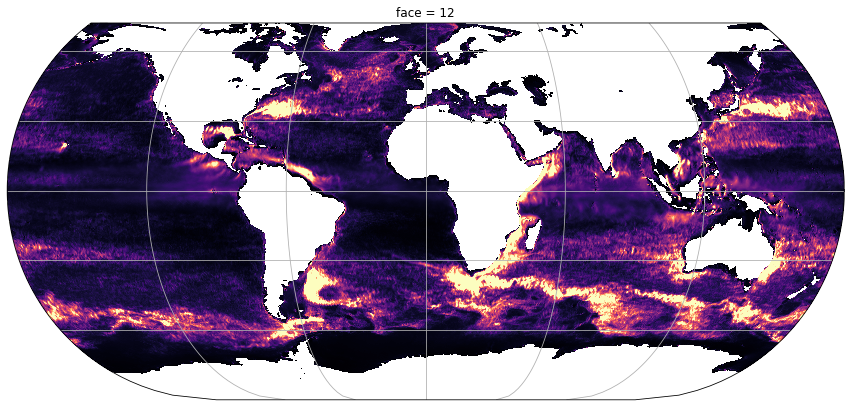

In [5]:
pl.plot_pretty(ds_low.variance_SSV,cmap='magma',vmax=0.1,land=False
              )

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/e

{'fig': <Figure size 1080x1080 with 1 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'face = 12'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': None}

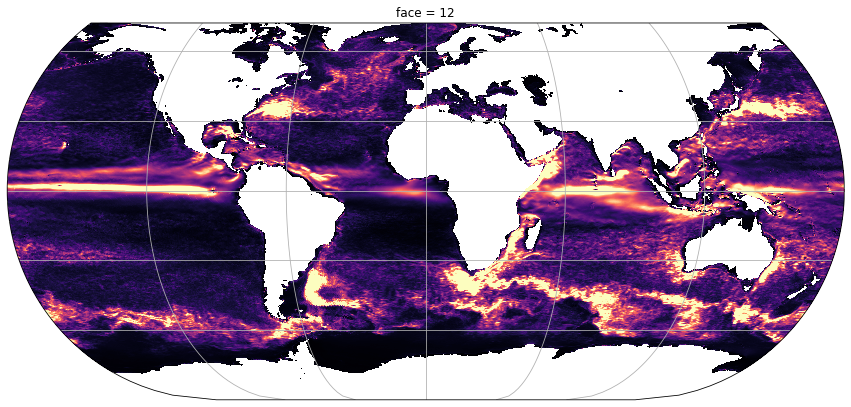

In [6]:
pl.plot_pretty(ds_low.variance_SSU,cmap='magma',vmax=0.1,land=False
              )

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/e

{'fig': <Figure size 1080x1080 with 1 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'face = 12'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': None}

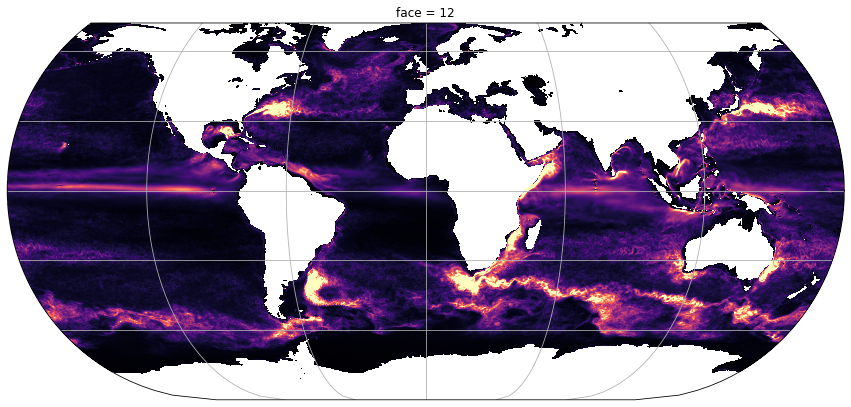

In [7]:
pl.plot_pretty(0.5*(ds_low.variance_SSU+ds_low.variance_SSV),cmap='magma',vmax=0.15,land=False
              )

In [12]:
ds_hf['XC'] = ds_low.XC
ds_hf['YC'] = ds_low.YC

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/e

{'fig': <Figure size 1080x1080 with 1 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'face = 12'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': None}

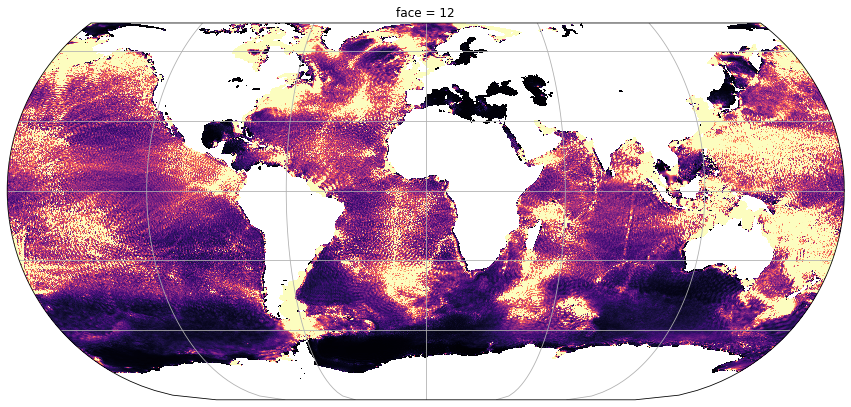

In [13]:
pl.plot_pretty(ds_hf.energy_SSU,cmap='magma',vmax=0.02,land=False)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/e

{'fig': <Figure size 1080x1080 with 1 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'face = 12'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': None}

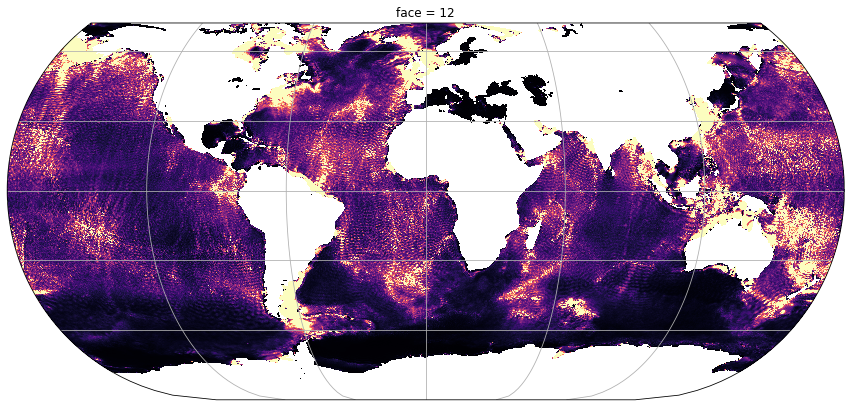

In [14]:
pl.plot_pretty(ds_hf.energy_SSV,cmap='magma',vmax=0.02,land=False)

In [ ]:
pl.plot_pretty(0.5(ds_hf.energy_SSU+ds_hf.energy_SSV),cmap='magma',vmax=0.02,land=False)

### Binning

In [51]:
dl = 1.
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-60, 60, dl)
V = 'energy'

In [52]:
N = histogram(ds_low.lon.rename('lon'), ds_low.lat.rename('lat'), 
              bins=[lon_bins,lat_bins], 
              dim=['i', 'j', 'face']
             ).persist()

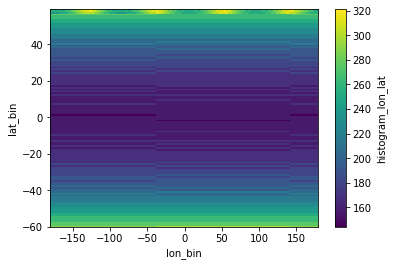

In [53]:
N.plot(y='lat_bin')

In [58]:
ds_binned = (histogram(ds_low.lon.rename('lon'), ds_low.lat.rename('lat'),bins=[lon_bins, lat_bins],
                       weights=ds_low[V].fillna(0.),
                       dim=['i', 'j', 'face'])/(N)).rename('E_%s'%V).persist()

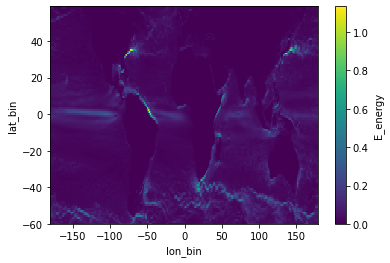

In [59]:
ds_binned.plot(y='lat_bin')

In [60]:
ds_binned = ds_binned.where(ds_binned>0)

In [61]:
dsE = xr.Dataset({'E_count':N,'E_'+V:ds_binned})
dsE = dsE.compute()
dsE

<xarray.Dataset>
Dimensions:   (lon_bin: 359, lat_bin: 119)
Coordinates:
  * lon_bin   (lon_bin) float64 -179.5 -178.5 -177.5 ... 176.5 177.5 178.5
  * lat_bin   (lat_bin) float64 -59.5 -58.5 -57.5 -56.5 ... 55.5 56.5 57.5 58.5
Data variables:
    E_count   (lon_bin, lat_bin) int64 288 276 276 264 264 ... 264 276 252 251
    E_energy  (lon_bin, lat_bin) float64 0.05609 0.06701 ... 0.01105 0.01181

In [62]:
def binning(_df,binsize):
    #lon_bins,lat_bins = np.arange(lonmin,lonmax,binsize),np.arange(latmin,latmax,binsize)
    x_idx,y_idx = pd.IntervalIndex.from_breaks(lon_bins),pd.IntervalIndex.from_breaks(lat_bins)
    _df['lon_cut'] = _df['lon'].map_partitions(pd.cut, bins=lon_bins)
    _df['lat_cut'] = _df['lat'].map_partitions(pd.cut, bins=lat_bins)
    _df = _df.drop(columns=['lon','lat','trajectory']) # ,'h'
    return _df
_df = binning(_df,dl).persist()

In [63]:
df_mean = _df.groupby(['lon_cut','lat_cut']).mean()
df_mean = df_mean.reset_index().persist()

In [64]:
df_count = _df.groupby(['lon_cut','lat_cut']).count().reset_index().persist()

In [65]:
df_count['lon_bin'] = df_count.lon_cut.apply(lambda x :x.mid)
df_count['lat_bin'] = df_count.lat_cut.apply(lambda x :x.mid)
df_count = df_count.drop(columns=['lon_cut','lat_cut']).compute()
df_count.head()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py:3764: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('lon_cut', 'category'))

  warnings.warn(meta_warning(meta))
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py:3764: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func

,energy,waterdepth,lon_bin,lat_bin
0,217,217,-179.5,-59.5
1,215,215,-179.5,-58.5
2,186,186,-179.5,-57.5
3,488,488,-179.5,-56.5
4,525,525,-179.5,-55.5


In [66]:
df_mean['lon_bin'] = df_mean.lon_cut.apply(lambda x :x.mid)
df_mean['lat_bin'] = df_mean.lat_cut.apply(lambda x :x.mid)
df_mean = df_mean.drop(columns=['lon_cut','lat_cut']).persist()
df_mean.head()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py:3764: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('lon_cut', 'category'))

  warnings.warn(meta_warning(meta))
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py:3764: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func

,energy,waterdepth,lon_bin,lat_bin
0,0.006527,4346.939804,-179.5,-59.5
1,0.011852,4967.515698,-179.5,-58.5
2,0.022972,5021.589046,-179.5,-57.5
3,0.045355,5057.304303,-179.5,-56.5
4,0.080511,5231.296667,-179.5,-55.5


In [67]:
df_mean = df_mean.compute()

In [68]:
dsL = df_mean.set_index(['lon_bin','lat_bin']).to_xarray().unstack()
dsL['L_count'] = df_count.set_index(['lon_bin','lat_bin']).to_xarray().unstack()['waterdepth']

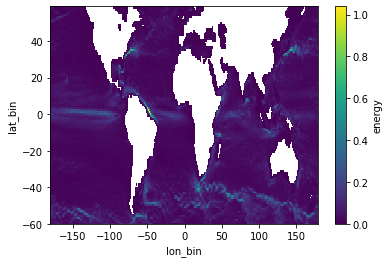

In [69]:
dsL.energy.plot(y='lat_bin')

In [70]:
ds = xr.merge([dsE,dsL.rename({V:'L_'+V})])
#ds = ds_binned
ds

<xarray.Dataset>
Dimensions:     (lon_bin: 359, lat_bin: 119)
Coordinates:
  * lon_bin     (lon_bin) float64 -179.5 -178.5 -177.5 ... 176.5 177.5 178.5
  * lat_bin     (lat_bin) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5
Data variables:
    E_count     (lon_bin, lat_bin) int64 288 276 276 264 264 ... 264 276 252 251
    E_energy    (lon_bin, lat_bin) float64 0.05609 0.06701 ... 0.01105 0.01181
    L_energy    (lon_bin, lat_bin) float64 0.006527 0.01185 ... 0.01034 0.01386
    waterdepth  (lon_bin, lat_bin) float64 4.347e+03 4.968e+03 ... 3.745e+03
    L_count     (lon_bin, lat_bin) int64 217 215 186 488 ... 9350 5994 6380 2066

In [71]:
ds.to_netcdf('/home1/datawork/zcaspar/mit4320/%s_binned_dl%s.nc'%(V,str(dl)))

In [5]:
#client.restart()
#
cluster.close()